In [1]:
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from PIL import Image, ImageDraw
from rich import print  # type: ignore # noqa
from readii.negative_controls_refactor import (
    NegativeControlManager,
    NEGATIVE_CONTROL_REGISTRY,
    REGION_REGISTRY
)


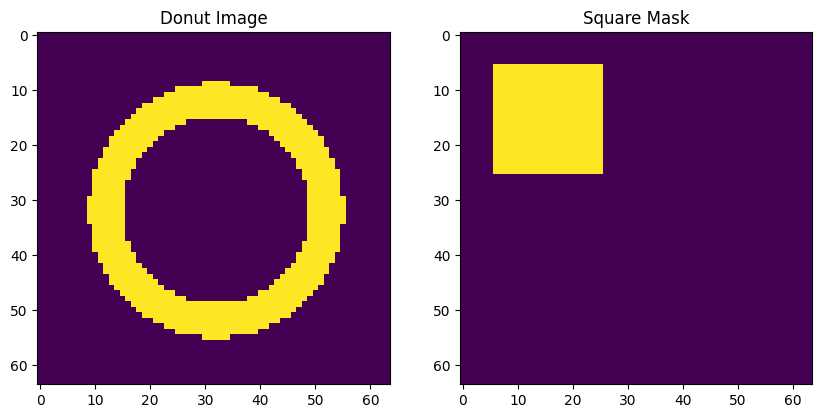

In [ ]:
def create_donut_image(size: int = 64, radius: int = 20, max_thickness: int = 10) -> sitk.Image:
  """Generate a 3D donut-shaped SimpleITK image with varying thickness across slices."""
  grid = np.zeros((size, size, size), dtype=np.uint8)
  center = size // 2
  mid_slice = size // 2

  for z in range(size):
    # Calculate thickness for current slice based on distance from the middle slice
    thickness = max_thickness * (1 - abs(z - mid_slice) / mid_slice)  # Linear scaling
    for x in range(size):
      for y in range(size):
        distance_from_center = np.sqrt((x - center) ** 2 + (y - center) ** 2)
        if radius - thickness <= distance_from_center <= radius + thickness:
          grid[z, x, y] = 255  # Donut drawn along Z-axis (top-down view)

  return sitk.GetImageFromArray(grid)

def create_square_mask(image: sitk.Image, side_length: int = 20) -> sitk.Image:
  """
  Create a square mask for a given SimpleITK image.

  The square is placed in the top-left quadrant of the image, covering part of the donut.

  Parameters
  ----------
  image : sitk.Image
      The input image for which the mask is created.
  side_length : int, default 20
      The length of one side of the square mask in pixels.

  Returns
  -------
  sitk.Image
      A binary mask image with the square region set to 1.
  """
  # Get the dimensions of the input image
  size = sitk.GetArrayFromImage(image).shape  # (z, y, x)

  # Define the position of the square in the top-left quadrant
  # Offset from the center to ensure it covers part of the donut
  start_x = size[2] // 4 - side_length // 2
  start_y = size[1] // 4 - side_length // 2

  # Ensure the square is within bounds
  start_x = max(0, start_x)
  start_y = max(0, start_y)
  end_x = min(size[2], start_x + side_length)
  end_y = min(size[1], start_y + side_length)

  # Create the mask array
  mask = np.zeros(size, dtype=np.uint8)
  mask[:, start_y:end_y, start_x:end_x] = 1  # Apply the square ROI to all slices

  # Convert the mask to a SimpleITK image
  return sitk.GetImageFromArray(mask)


In [ ]:
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from typing import List
import SimpleITK as sitk


class VisualizeNegativeControl:
    """
    Class for visualizing and saving negative control strategies applied to images.

    Attributes
    ----------
    results_dir : Path
        Directory to save all generated GIFs.
    """

    def __init__(self, results_dir: Path) -> None:
        """
        Initialize the VisualizeNegativeControl class.

        Parameters
        ----------
        results_dir : Path
            Directory to save the results.
        """
        self.results_dir = results_dir
        self.results_dir.mkdir(exist_ok=True)

    def save_gif_from_slices(self, sitk_image: sitk.Image, output_path: Path, control_name: str = None, region_name: str = None) -> None:
        """
        Save a 3D SimpleITK image as an animated GIF with optional text overlay.

        Parameters
        ----------
        sitk_image : sitk.Image
            The 3D SimpleITK image to save as a GIF.
        output_path : Path
            The file path to save the GIF.
        control_name : str, optional
            The name of the control strategy (to overlay on the image).
        region_name : str, optional
            The name of the region strategy (to overlay on the image).

        Returns
        -------
        None
        """
        array = sitk.GetArrayFromImage(sitk_image)  # Convert to numpy array
        slices = [
            Image.fromarray(array[i]).resize((256, 256), Image.Resampling.NEAREST)
            for i in range(array.shape[0])
        ]

        text_height = 30  # Height for text area
        for i, img in enumerate(slices):
            new_img = Image.new('L', (256, 256 + text_height), color=0)
            new_img.paste(img, (0, text_height))
            
            if control_name or region_name:
                draw = ImageDraw.Draw(new_img)
                text = f"{control_name or ''} | {region_name or ''}".strip(" | ")
                font = ImageFont.load_default(size=20)
                
                text_width = draw.textlength(text, font=font)
                draw.text(
                    ((new_img.width - text_width) // 2, 5),
                    text,
                    fill="white",
                    font=font,
                )
            
            slices[i] = new_img

        slices[0].save(
            output_path,
            save_all=True,
            append_images=slices[1:],
            duration=100,
            loop=0,
        )

    def create_large_gif(self, output_path: Path, control_files: List[Path], original_file: Path) -> None:
        """
        Create a large GIF combining multiple smaller GIFs into a grid.

        Parameters
        ----------
        output_path : Path
            Path to save the resulting large GIF.
        control_files : list of Path
            List of file paths for the control GIFs to arrange in a 3x3 grid.
        original_file : Path
            Path to the original GIF to be placed to the right of the grid.

        Returns
        -------
        None
        """
        control_frames = [Image.open(f) for f in control_files]
        original_frames = Image.open(original_file)

        # Get dimensions of a single frame
        frame_width, frame_height = control_frames[0].size
        num_frames = min(
            [gif.n_frames for gif in control_frames] + [original_frames.n_frames]
        )

        # Define padding
        padding = 10

        # Dimensions for the large GIF
        grid_width = (frame_width * 3) + (padding * 2)
        grid_height = (frame_height * 3) + (padding * 2)
        total_width = grid_width + frame_width + padding

        combined_frames = []
        for i in range(num_frames):
            combined_frame = Image.new("RGB", (total_width, grid_height), "black")
            for j, control_frame in enumerate(control_frames):
                control_frame.seek(i)
                x_offset = (j % 3) * frame_width + ((j % 3) * padding)
                y_offset = (j // 3) * frame_height + ((j // 3) * padding)
                combined_frame.paste(control_frame, (x_offset, y_offset))

            original_frames.seek(i)
            combined_frame.paste(original_frames, (grid_width + padding, 0))

            combined_frames.append(combined_frame)

        combined_frames[0].save(
            output_path,
            save_all=True,
            append_images=combined_frames[1:],
            duration=100,
            loop=0,
        )
        print(f"Large GIF saved at {output_path}")
# Create test images
donut_image = create_donut_image()
square_mask = create_square_mask(donut_image, side_length=10)

print(REGION_REGISTRY, NEGATIVE_CONTROL_REGISTRY)
# Create NegativeControlManager from string inputs
manager = NegativeControlManager.from_strings(
    negative_control_types=["sampled", "randomized", "shuffled"],
    region_types=["roi", "non_roi", "full"],
    random_seed=42,
)

print(manager)
results = list(manager.apply(donut_image, square_mask))
print(results)
result_dir = Path("TRASH", "results")
result_dir.mkdir(exist_ok=True, parents=True)
visualizer = VisualizeNegativeControl(results_dir=result_dir)
control_paths = []

visualizer.save_gif_from_slices(donut_image,  visualizer.results_dir / "original.gif")

for i, (image, control_name, region_name) in enumerate(results):
    output_path = Path("TRASH", "results", f"{control_name}_{region_name}.gif")
    visualizer.save_gif_from_slices(image, output_path, control_name=control_name, region_name=region_name)
    control_paths.append(output_path)

# Create a large GIF combining all control strategies
visualizer.create_large_gif(
    output_path=Path("TRASH", "results", "combined.gif"),
    control_files=control_paths,
    original_file=Path("TRASH", "results", "original.gif"),
)


{
    'full': <class 'readii.negative_controls_refactor.FullRegion'>,
    'roi': <class 'readii.negative_controls_refactor.ROIRegion'>,
    'non_roi': <class 'readii.negative_controls_refactor.NonROIRegion'>
}
{
    'shuffled': <class 'readii.negative_controls_refactor.ShuffledControl'>,
    'sampled': <class 'readii.negative_controls_refactor.SampledControl'>,
    'randomized': <class 'readii.negative_controls_refactor.RandomizedControl'>
}

NegativeControlManager(
    negative_control_strategies=[
        SampledControl(random_seed=42),
        RandomizedControl(random_seed=42),
        ShuffledControl(random_seed=42)
    ],
    region_strategies=[
        <readii.negative_controls_refactor.ROIRegion object at 0x12fc87260>,
        <readii.negative_controls_refactor.NonROIRegion object at 0x12fc86c00>,
        <readii.negative_controls_refactor.FullRegion object at 0x12fdbe120>
    ]
)

[
    (
        <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x12fe6d8c0> >,
        'sampled',
        'roi'
    ),
    (
        <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x12fe17e70> >,
        'sampled',
        'non_roi'
    ),
    (
        <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x12fe18a20> >,
        'sampled',
        'full'
    ),
    (
        <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x12fe1bc90> >,
        'randomized',
        'roi'
    ),
    (
        <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x12fe19ec0> >,
        'randomized',
        'non_roi'
    ),
    (
        <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x12fe1b810> >,
        'randomized',
        'full'
    ),
    (
        <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x12fdeb6c0> >,
        'shuffled',
        'roi'
    ),
    (
        <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x12fdea5b0> >,
        'shuffled',
        'non_roi'
    ),
    (
        <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x12fdebe40> >,
        'shuffled',
        'full'
    )
]